# Power calculations with Pf-Tent
Our goal is to identify antigenic loci in Pf genome based on wgs sequencing & metadata from longitudinal birth cohorts. In theory, we should have a record of every Pf infection a child had while developing immunity to malaria. Here I'm using a longitudinal model of within-host malaria dynamics -- Pf-tent -- to perform power calculations to see if this goal is possible.

I hypothesize that if an antigenic allele has been observed before, future infections with parasites carrying that allele will result in shorter infection lengths & lower parasite density. Similarly, I hypothesize that we will have a lower probability of observing that allele again compared to alleles at non-antigenic loci.

In [1]:
import pfTent as tent
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

## Validating Pf-tent
First, I just want to make sure that pf-tent is working as expected and resulting in reasonable dynamics. Let's check results of simulations for 100 people.

In [2]:
y=5 # Simulate for 5 years
a = [5,5,5,5] # control,antigenic loci 1, antigenic loci 2, antigenic loci 3
w = [0,0,0.333333,0.3333333,0.333333] # general immunity, control, antigenic loci 1, antigenic loci 2, antigenic loci 3
n_people = 100

In [11]:
all_parasites = np.zeros((n_people, len(a), max(a), y*365))
all_strain_immunity = np.zeros((n_people, len(a), max(a), y*365))
all_gen_immunity = np.zeros((n_people,y*365))
all_parasite_density = []
all_infection_lengths = []
all_MOI = []
all_percent_parasitemia = []
all_malaria_rate = []

for person in range(n_people):
    pmatrix, smatrix, imatrix, ivector, malaria = tent.simulate_person(y,a,w,immune_thresh=0.01)
    
    Parasitemia, perPositivity = tent.check_parasitemia(3,pmatrix)
    MOI = tent.check_moi(3,smatrix)
    infectionlengths = tent.check_infection_length(smatrix,y,malaria)
    malaria_per_year = len(malaria)/y
    
    all_parasites[person,:,:,:] = pmatrix
    all_strain_immunity[person,:,:,:] = imatrix
    all_gen_immunity[person,:] = ivector
    all_parasite_density.extend(Parasitemia)
    all_infection_lengths.extend(infectionlengths)
    all_MOI.extend(MOI)
    all_percent_parasitemia.append(perPositivity)
    all_malaria_rate.append(malaria_per_year)

In [12]:
all_parasite_density = np.asarray(all_parasite_density)
logPdensity = np.log10(all_parasite_density[all_parasite_density != 0])

Parasite density
min:0.0
max:1235618.3746932568
median:3.839211794534771
mean:2861.8912947068125
std:25516.345997330554
---------------------
Infection length
min:1
max:447
median:69.0
mean:79.32709348692956
std:65.80359490859654
---------------------
MOI
min:0
max:16
median:4.0
mean:4.085405405405405
std:2.8178490882755067
---------------------
% Parasitemia
min:0.8108108108108109
max:0.972972972972973
median:0.918918918918919
mean:0.9124324324324324
std:0.041540813095872105
---------------------
Malaria cases per year
min:0.6
max:3.0
median:1.5
mean:1.4779999999999998
std:0.41751167648342485
---------------------


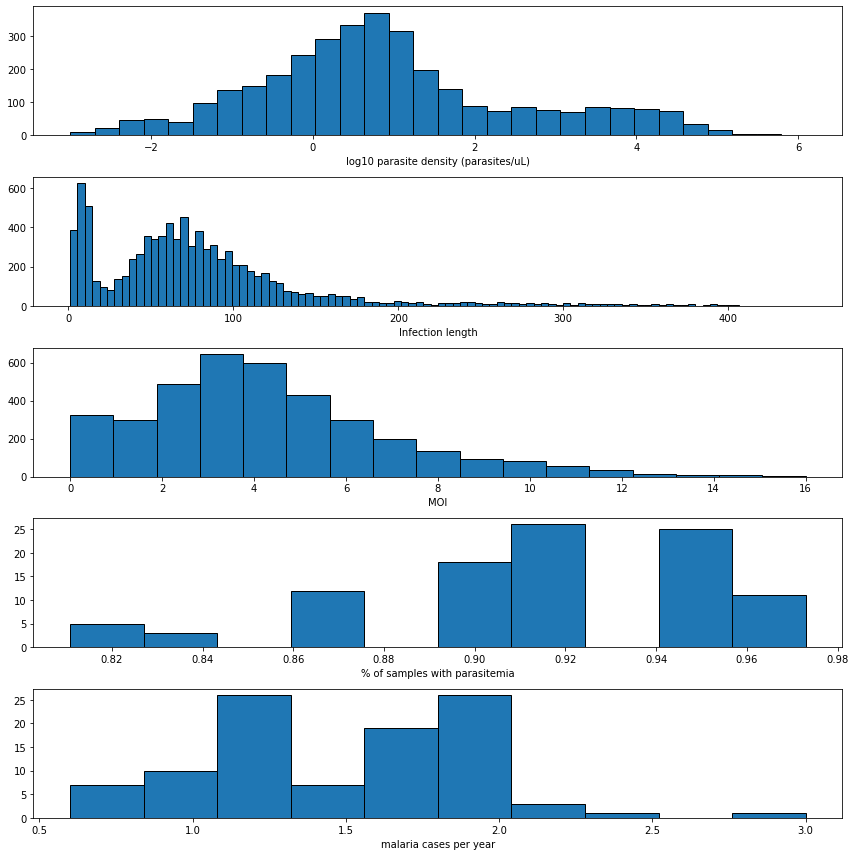

In [13]:
fig,ax = plt.subplots(nrows = 5, tight_layout=True, figsize=(12,12))
ax[0].hist(logPdensity, bins=30, edgecolor = "black")
ax[0].set_xlabel('log10 parasite density (parasites/uL)')
#ax[0].set_yscale('log')
#ax[0].set_xscale('log')
ax[1].hist(all_infection_lengths, bins=100, edgecolor = "black")
ax[1].set_xlabel('Infection length')
ax[2].hist(all_MOI, bins=(max(all_MOI)+1), edgecolor = "black")
ax[2].set_xlabel('MOI')
ax[3].hist(all_percent_parasitemia, bins=10, edgecolor = "black")
ax[3].set_xlabel('% of samples with parasitemia')
ax[4].hist(all_malaria_rate, bins=10, edgecolor = "black")
ax[4].set_xlabel('malaria cases per year')

results = [all_parasite_density, all_infection_lengths, all_MOI, all_percent_parasitemia, all_malaria_rate]
labels = ['Parasite density', 'Infection length', 'MOI', '% Parasitemia', 'Malaria cases per year']

for values, l in zip(results, labels):
    print(l)
    print('min:' + str(min(values)))
    print('max:' + str(max(values)))
    print('median:' + str(np.median(values)))
    print('mean:' + str(np.average(values)))
    print('std:' + str(np.std(values)))
    print('---------------------')

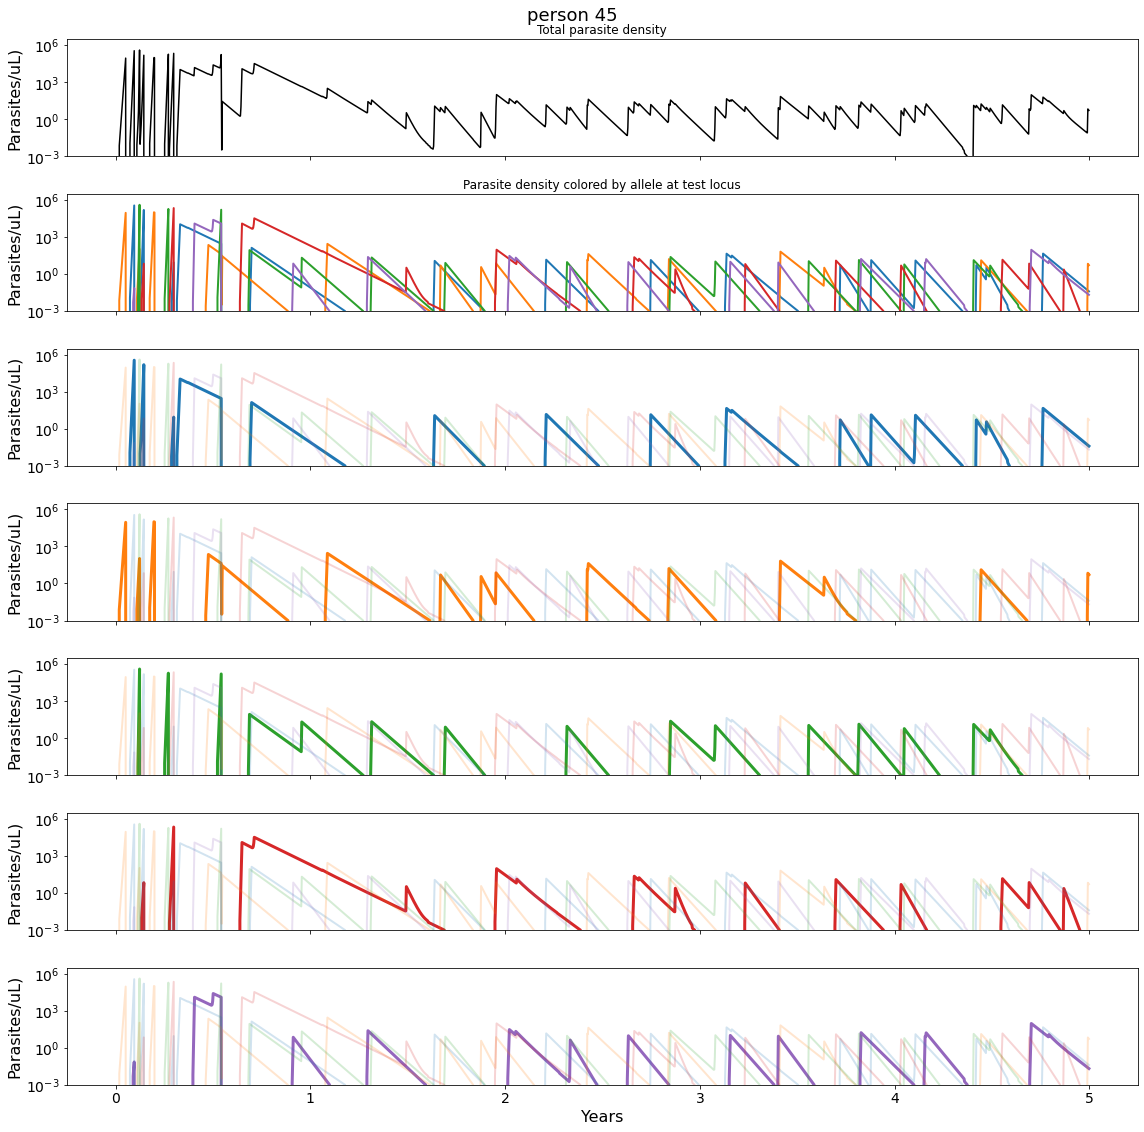

In [14]:
colors = {0:"tab:blue", 1:"tab:orange", 2:"tab:green", 3:"tab:red", 4:"tab:purple"}

for i in range(45,n_people,100):
    fig, ax = plt.subplots(nrows=7, sharey=True, sharex=True, tight_layout=True, figsize=(16,16))
    ax[0].tick_params(axis='both', which='major', labelsize=14)
    ax[1].tick_params(axis='both', which='major', labelsize=14)
    ax[0].set_yscale('log')
    ax[0].plot(np.arange(y*365)/365, all_parasites[i,-1,:,:].sum(axis=0),color="black")
    for strain in np.arange(5):
        iStrain = all_parasites[i,-1,strain,:]
        if np.sum(iStrain) > 1:
            ax[1].plot(np.arange(y*365)/365, iStrain, linewidth=2,color=colors[strain])
    ax[0].set_ylim(0.001,3000000)
    fig.suptitle('person ' + str(i),fontsize=18)
    ax[6].set_xlabel('Years',fontsize=16)
    ax[0].set_ylabel('Parasites/uL)',fontsize=16)
    ax[0].set_title('Total parasite density')
    ax[1].set_title('Parasite density colored by allele at test locus')
    ax[1].set_ylabel('Parasites/uL)',fontsize=16)
    for row in range(2,7):
        ax[row].tick_params(axis='both', which='major', labelsize=14)
        ax[row].set_ylabel('Parasites/uL)',fontsize=16)
        other = [strain for strain in range(0,5) if strain != row-2]
        ax[row].plot(np.arange(y*365)/365, all_parasites[i,-1,row-2,:],linewidth=3,color=colors[row-2])
        for strain in other:
            ax[row].plot(np.arange(y*365)/365, all_parasites[i,-1,strain,:],linewidth=2,alpha=0.2,color=colors[strain])


I'm getting somewhat of a drop in parasite density after first exposure. But the difference seems to stabilize around parasite density = 10. And for the purple allele, 2nd is actually higher than first because the first got cutoff prematurely due to treating another infection.

Should try changing immune gaining threshold as this is set to parasite density = 10. In initial validation, this was necessary to get accurate summary statistics.

## Power calculations
Or at least getting started on the problem...

In [15]:
def create_weight_alleles(loci, alleles):
    '''
    Returns weight & allele vectors.
    '''
    starter = np.ones(loci)
    zero = np.zeros(1)
    a = alleles * np.append(np.ones(1), starter)
    a = a.astype(int)
    strain = starter * (1/loci)
    w = np.append(np.zeros(2), strain)
    return a, w


def run_simulation(alleles,a,w,n_people,y):
    for person in range(n_people):                              
        pmatrix, smatrix, imatrix, ivector, malaria = tent.simulate_person(y,a,w)
        
        seen = np.zeros((2,alleles+1), dtype=int)
        lengths = np.zeros((2,alleles+1), dtype=int)
        
        visits = list(range(28,3*365,28))
        visits.extend(malaria)
        for t in np.sort(visits):
            control = pmatrix[0,:,t]
            test = pmatrix[-1,:,t]
            
            for i in range(alleles):
                if control[i] > 0:
                    if seen[0,i] == 0:
                        pdensity_control_unseen.append(control[i])
                        seen[0,i] = 1
                        lengths[0,i] = -1
                        observed[0,0,person] += 1
                    else:
                        pdensity_control_seen.append(control[i])
                        observed[0,1,person] += 1
                        if lengths[0,i] < 0:
                            lengths[0,i] += -1
                        else:
                            lengths[0,i] += 1
                else:
                    if lengths[0,i] != 0:
                        if lengths[0,i] < 0:
                            length_control_unseen.append(abs(lengths[0,i]))
                        else:
                            length_control_seen.append(abs(lengths[0,i]))
                        lengths[0,i] = 0
                
                if test[i] > 0:
                    if seen[1,i] == 0:
                        pdensity_test_unseen.append(test[i])
                        seen[1,i] = 1
                        lengths[1,i] = -1
                        observed[1,0,person] += 1
                    else:
                        pdensity_test_seen.append(test[i])
                        observed[1,1,person] += 1
                        if lengths[1,i] < 0:
                            lengths[1,i] += -1
                        else:
                            lengths[1,i] += 1
                else:
                    if lengths[1,i] != 0:
                        if lengths[1,i] < 0:
                            length_test_unseen.append(abs(lengths[1,i]))
                        else:
                            length_test_seen.append(abs(lengths[1,i]))
                        lengths[1,i] = 0
                        
        all_parasites[person,:,:,:] = pmatrix
        all_strain_immunity[person,:,:,:] = imatrix
        all_gen_immunity[person,:] = ivector

In [31]:
n_people=30
alleles = 20
antigens = 1
y = 5
genetics, weight = create_weight_alleles(antigens,alleles)
print(genetics)
print(weight)

all_parasites = np.zeros((n_people, antigens+1, alleles, y*365))
all_strain_immunity = np.zeros((n_people, antigens+1, alleles, y*365))
all_gen_immunity = np.zeros((n_people,y*365))
pdensity_control_unseen = []
pdensity_control_seen = []
pdensity_test_unseen = []
pdensity_test_seen = []

length_control_unseen = []
length_control_seen = []
length_test_unseen = []
length_test_seen = []

observed = np.zeros((2,2,n_people),dtype=int)

run_simulation(alleles,genetics,weight,n_people,y)

[20 20]
[0. 0. 1.]


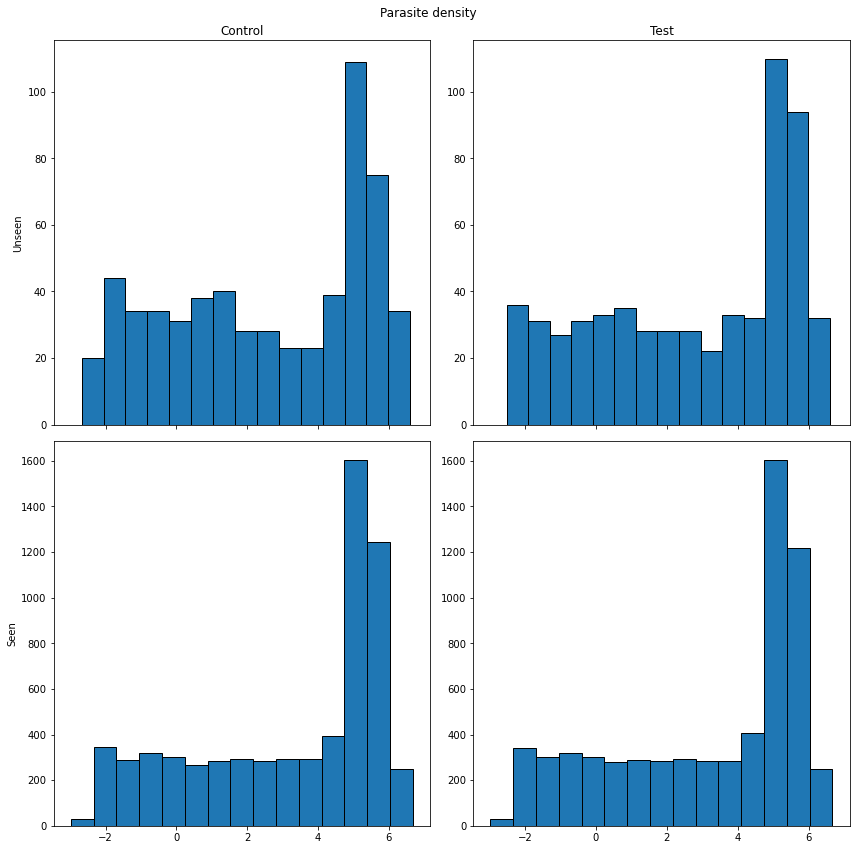

In [32]:
fig,ax = plt.subplots(nrows = 2,ncols=2,sharex=True, tight_layout=True, figsize=(12,12))
ax[0,0].hist(np.log10(pdensity_control_unseen), bins=15, edgecolor = "black")
ax[1,0].hist(np.log10(pdensity_control_seen), bins=15, edgecolor = "black")
ax[0,1].hist(np.log10(pdensity_test_unseen), bins=15, edgecolor = "black")
ax[1,1].hist(np.log10(pdensity_test_seen), bins=15, edgecolor = "black")
ax[0,0].set_title("Control")
ax[0,0].set_ylabel("Unseen")
ax[1,0].set_ylabel("Seen")
ax[0,1].set_title("Test")
fig.suptitle("Parasite density")
ax[0,0].get_shared_y_axes().join(ax[0,0], ax[0,1])
ax[1,0].get_shared_y_axes().join(ax[1,0], ax[1,1])

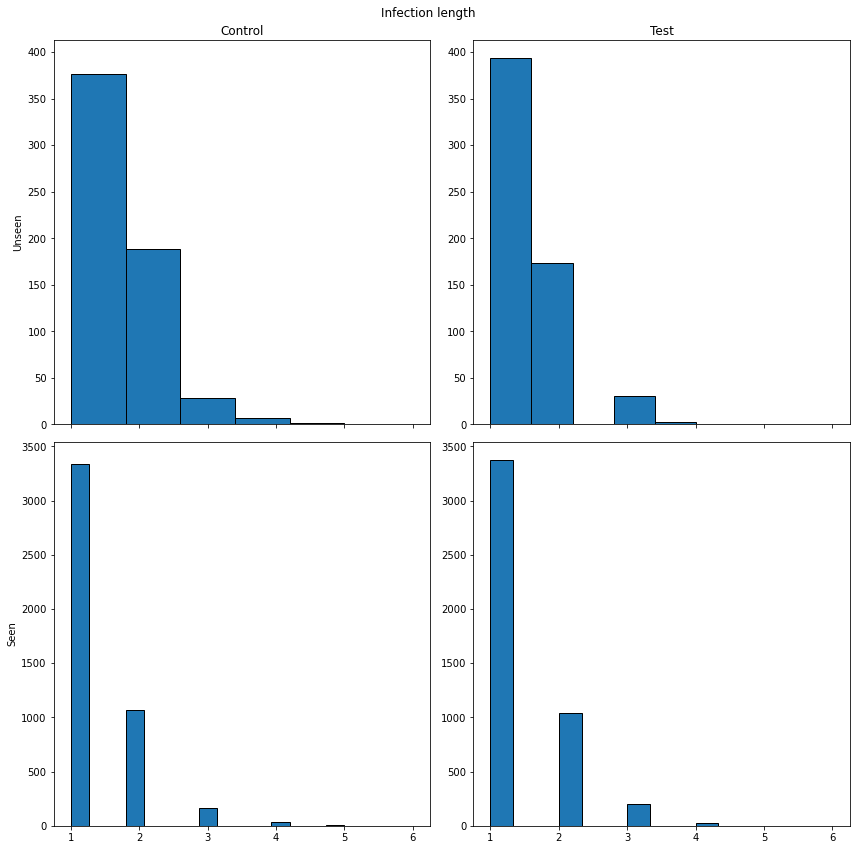

In [34]:
fig,ax = plt.subplots(nrows = 2,ncols=2,sharex=True, tight_layout=True, figsize=(12,12))
ax[0,0].hist(length_control_unseen, bins=5,edgecolor="black")
ax[1,0].hist(length_control_seen, bins=15,edgecolor="black")
ax[0,1].hist(length_test_unseen, bins=5,edgecolor="black")
ax[1,1].hist(length_test_seen, bins=15,edgecolor="black")
ax[0,0].set_title("Control")
ax[0,0].set_ylabel("Unseen")
ax[1,0].set_ylabel("Seen")
ax[0,1].set_title("Test")
fig.suptitle("Infection length")
ax[0,0].get_shared_y_axes().join(ax[0,0], ax[0,1])
ax[1,0].get_shared_y_axes().join(ax[1,0], ax[1,1])

Probably need to cut infection length if infection was treated and only focus on untreated infections.

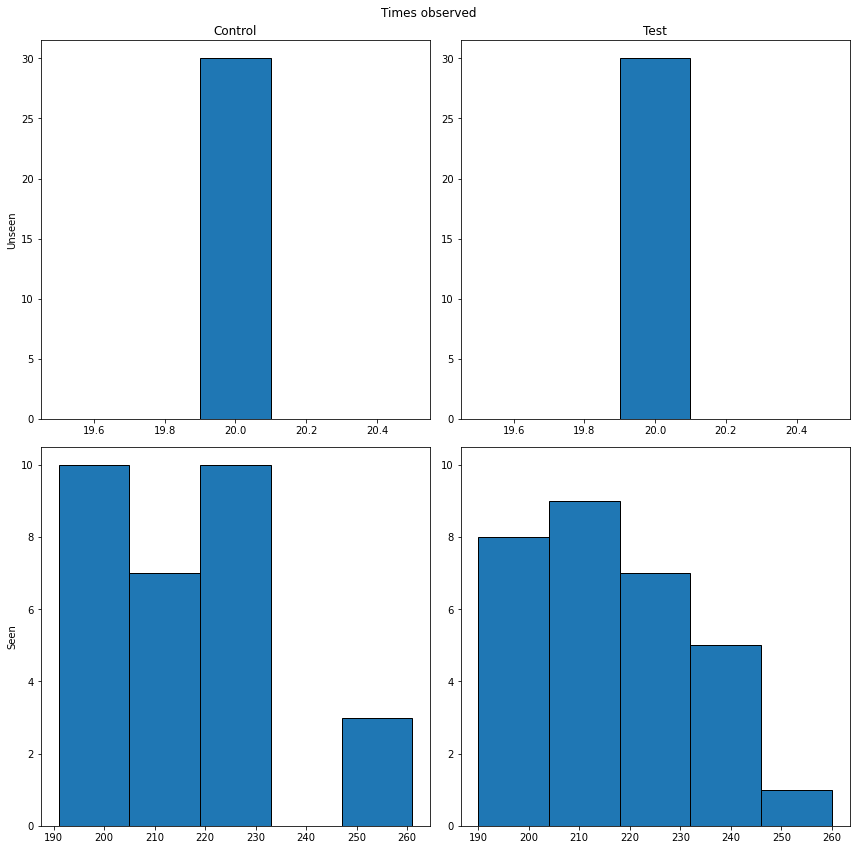

In [35]:
fig,ax = plt.subplots(nrows = 2,ncols=2, tight_layout=True, figsize=(12,12))
ax[0,0].hist(observed[0,0,:], bins=5,edgecolor="black")
ax[1,0].hist(observed[0,1,:], bins=5,edgecolor="black")
ax[0,1].hist(observed[1,0,:], bins=5,edgecolor="black")
ax[1,1].hist(observed[1,1,:], bins=5,edgecolor="black")
ax[0,0].set_title("Control")
ax[0,0].set_ylabel("Unseen")
ax[1,0].set_ylabel("Seen")
ax[0,1].set_title("Test")
fig.suptitle("Times observed")
ax[0,0].get_shared_y_axes().join(ax[0,0], ax[0,1])
ax[1,0].get_shared_y_axes().join(ax[1,0], ax[1,1])

If there's only one antigen, get lots of infections at high parasitemia because immunity never builds up. Maybe need to gain immunity a LOT faster.

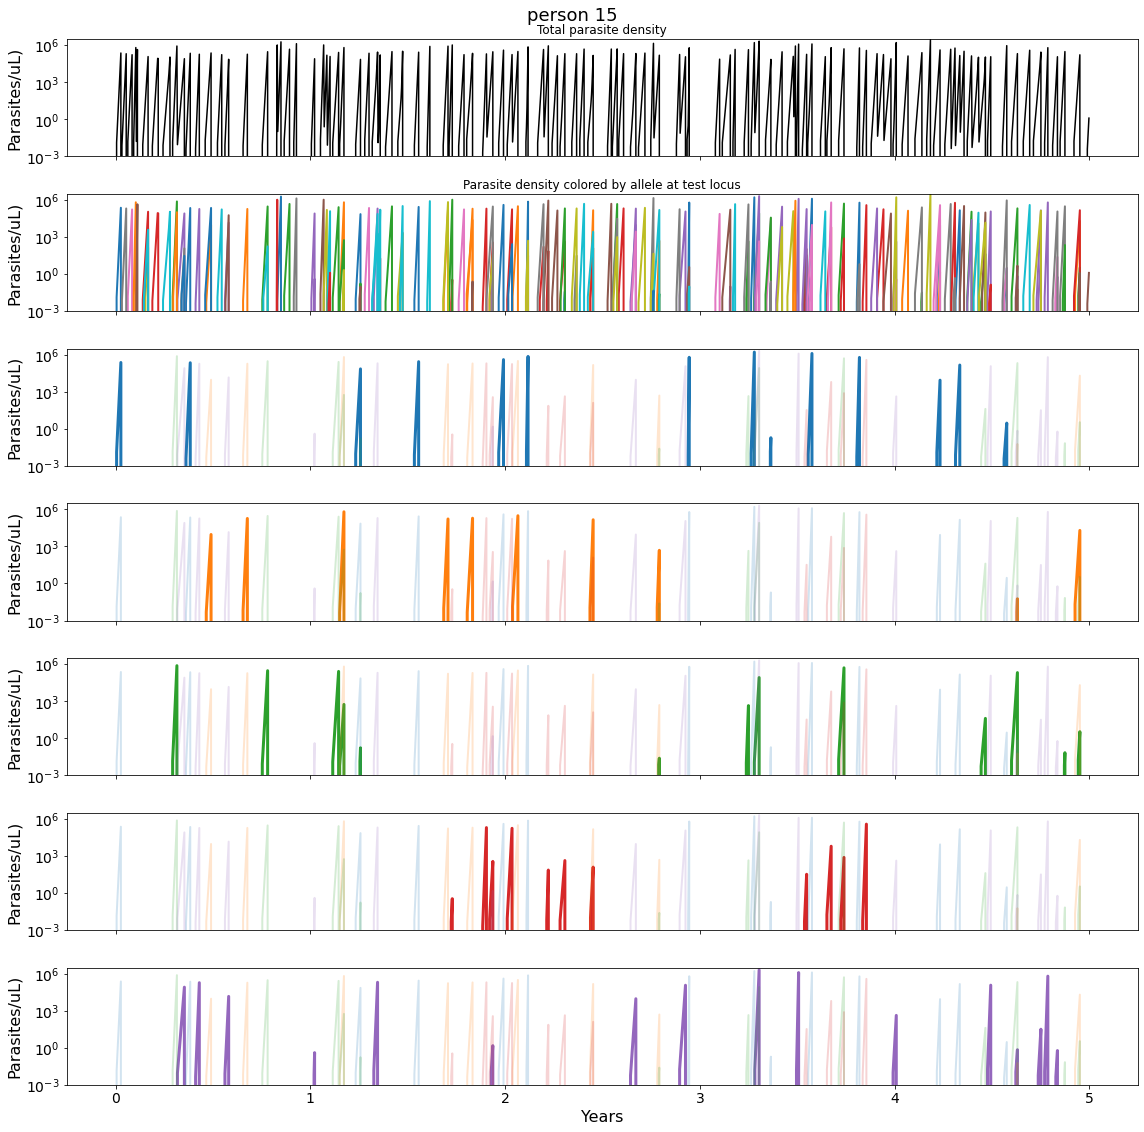

In [39]:
colors = {0:"tab:blue", 1:"tab:orange", 2:"tab:green", 3:"tab:red", 4:"tab:purple"}

for i in range(15,n_people,20):
    fig, ax = plt.subplots(nrows=7, sharey=True, sharex=True, tight_layout=True, figsize=(16,16))
    ax[0].tick_params(axis='both', which='major', labelsize=14)
    ax[1].tick_params(axis='both', which='major', labelsize=14)
    ax[0].set_yscale('log')
    ax[0].plot(np.arange(y*365)/365, all_parasites[i,-1,:,:].sum(axis=0),color="black")
    for strain in np.arange(20):
        iStrain = all_parasites[i,-1,strain,:]
        if np.sum(iStrain) > 1:
            ax[1].plot(np.arange(y*365)/365, iStrain, linewidth=2)#,color=colors[strain])
    ax[0].set_ylim(0.001,3000000)
    fig.suptitle('person ' + str(i),fontsize=18)
    ax[6].set_xlabel('Years',fontsize=16)
    ax[0].set_ylabel('Parasites/uL)',fontsize=16)
    ax[0].set_title('Total parasite density')
    ax[1].set_title('Parasite density colored by allele at test locus')
    ax[1].set_ylabel('Parasites/uL)',fontsize=16)
    for row in range(2,7):
        ax[row].tick_params(axis='both', which='major', labelsize=14)
        ax[row].set_ylabel('Parasites/uL)',fontsize=16)
        other = [strain for strain in range(0,5) if strain != row-2]
        ax[row].plot(np.arange(y*365)/365, all_parasites[i,-1,row-2,:],linewidth=3,color=colors[row-2])
        for strain in other:
            ax[row].plot(np.arange(y*365)/365, all_parasites[i,-1,strain,:],linewidth=2,alpha=0.2,color=colors[strain])


In [ ]:
hmmmmmm method doesn't work with only 1 locus, but it looks more reasonable....

In [2]:
i = 1
total_time = 20
while i <= 100:
    time = 20 + 1.2*i
    total_time += time
    i+= 1
    

In [4]:
total_time/60

134.66666666666666